# 4.1.2 PID 

In [1]:
import pickle
import os
import glob
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind, mannwhitneyu
from analysis.roi_utils import normalize_roi_name
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="muted")

In [2]:
# Define hierarchical brain regions for visual system
def hierarchy(system):
    if system == 'visual':
        HIERARCHY = {
            'Primary': ['VISp'],                   # Primary visual cortex
            'Secondary': ['VISl', 'VISrl', 'VISa'], # Secondary visual areas
            'Higher': ['VISam', 'VISpm'],          # Higher visual association areas
            'Visuospatial': ['RSPd', 'RSPv']       # Visuospatial processing areas
        }
    elif system == 'motor':
        HIERARCHY = {
            'Primary': ['MOp'],                   # Primary motor cortex
            'Secondary': ['MOs', 'PL'],           # Secondary motor areas
            'Premotor': ['FRP', 'ACAd', 'ACAv'],  # Premotor areas
            'BasalGanglia': ['STR', 'PAL'],       # Basal ganglia motor circuits
            'Brainstem': ['SCs', 'SNr', 'VTA', 'RN', 'PPN'],  # Brainstem motor nuclei
            'Somatosensory': ['SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'SSp-un', 'SSp-n', 'SSp-m']  # Somatosensory feedback areas
        }
    
    return HIERARCHY

def level_order(system):
    if system == 'visual':
        LEVER_ORDER = ['Primary', 'Secondary', 'Higher', 'Visuospatial']
    elif system == 'motor':
        LEVER_ORDER = ['Primary', 'Secondary', 'Premotor', 'BasalGanglia', 'Brainstem', 'Somatosensory']
    return LEVER_ORDER

# Define conditions to analyze
def target_condition(system):
    if system == 'visual':
        TARGET_CONDITIONS = ['VISp', 'VISa', 'VISam', 'RSPd']
    elif system == 'motor':
        TARGET_CONDITIONS = ['MOp', 'SSp-ul', 'MOs', 'SSp-bfd']

    return TARGET_CONDITIONS

def extract_condition_name(filename):
    """Extract full condition name (including /) from filename"""
    basename = os.path.basename(filename)
    parts = basename.split('_')
    
    # Handle special cases
    if 'VISa_rl' in basename:
        return 'VISa/rl (R)'
    elif 'VISam_pm' in basename:
        return 'VISam/pm (R)'
    elif 'RSPd_v' in basename:
        return 'RSPd/v (Bilateral)'
    elif 'VISp_' in basename:
        return 'VISp (L)'
    elif 'MOp_' in basename:
        return 'MOp (L)'
    elif 'MOs_' in basename:
        return 'MOs (R)'
    elif 'SSp_ul' in basename:
        return 'SSp-ul/ll (R)'
    elif 'SSp_bfd' in basename:
        return 'SSp-bfd (L)'
    elif 'SSp_ll' in basename:
        return 'SSp-ul/ll (R)'
    else:
        return parts[2]  # Default to third part

In [ ]:
def load_and_process_data(results_folder, system):
    """Load and process PID data matching your file naming convention"""
    
    # Validate input folder
    if not os.path.exists(results_folder):
        raise FileNotFoundError(f"Results folder not found: {results_folder}")
    
    # Get system-specific parameters
    TARGET_CONDITIONS = target_condition(system)
    HIERARCHY = hierarchy(system)
    
    # Find all matching files for this system
    system_files = []
    for cond in TARGET_CONDITIONS:
        # Match files like results_VISp (L).pkl or results_VISp (L).npz
        pattern = os.path.join(results_folder, f"results_*{cond}*.pkl") 
        matches = glob.glob(pattern)
        system_files.extend(matches)
    
    rest_files = glob.glob(os.path.join(results_folder, 'results_Rest.pkl'))
    
    if not system_files:
        raise ValueError(f"No files found for {system} system")
    if not rest_files:
        raise ValueError("No Rest condition file found")
    
    print(f"Found {len(system_files)} {system} files and {len(rest_files)} Rest files")

    # Load Rest data
    with open(rest_files[0], 'rb') as f:
        rest_result = pickle.load(f)
        roi_names = rest_result['metadata']['roi_names']
    
    # Process each condition file
    all_data = []
    pid_atoms = ['R', 'U_X', 'U_Y', 'S']
    
    for cond_file in system_files:
        cond_name = os.path.basename(cond_file).replace('results_', '').replace('.pkl', '')
        print(f"\nProcessing {cond_name}...")
        
        with open(cond_file, 'rb') as f:
            cond_result = pickle.load(f)
        
        # Process both Rest and current condition
        for condition, data in [('Rest', rest_result), (cond_name, cond_result)]:
            if condition not in data['conditions']:
                continue
                
            print(f"  Analyzing {condition}")
            
            for pair_key, pair_data in data['conditions'][condition]['roi_pairs'].items():
                if 'roi_info' not in pair_data or 'PID' not in pair_data:
                    continue
                    
                # Get ROI information
                i, j = pair_data['roi_info']['indices']
                roi1, roi2 = roi_names[i], roi_names[j]
                roi1_norm, roi2_norm = normalize_roi_name(roi1), normalize_roi_name(roi2)
                
                # Check if ROIs belong to target system
                target_rois = [roi for level in HIERARCHY.values() for roi in level]
                if not (roi1_norm in target_rois or roi2_norm in target_rois):
                    continue
                
                # Get hierarchy levels
                level1 = next((lvl for lvl, rois in HIERARCHY.items() if roi1_norm in rois), None)
                level2 = next((lvl for lvl, rois in HIERARCHY.items() if roi2_norm in rois), None)
                
                try:
                    entry = {
                        'ROI1': roi1_norm,
                        'ROI2': roi2_norm,
                        'Level1': level1,
                        'Level2': level2,
                        'Condition': condition,
                        'Stim_Condition': cond_name if condition != 'Rest' else 'Rest',
                        **{atom: pair_data['PID']['mean'][atom] for atom in pid_atoms}
                    }
                    
                    # Mark stimulated regions
                    if condition != 'Rest':
                        entry['Is_Stimulated'] = cond_name in [roi1_norm, roi2_norm]
                    
                    all_data.append(entry)
                    
                except (KeyError, TypeError) as e:
                    print(f"    Skipping invalid PID data for {roi1_norm}-{roi2_norm}: {str(e)}")
                    continue
    
    if not all_data:
        raise ValueError("No valid PID data extracted")
        
    # Create DataFrame and calculate changes
    df = pd.DataFrame(all_data)
    
    if 'Rest' in df['Condition'].unique():
        rest_df = df[df['Condition'] == 'Rest'].copy()
        cond_df = df[df['Condition'] != 'Rest'].copy()
        
        merged = cond_df.merge(
            rest_df, 
            on=['ROI1', 'ROI2'], 
            suffixes=('', '_Rest')
        )
        
        for atom in pid_atoms:
            merged[f'{atom}_Change'] = merged[atom] - merged[f'{atom}_Rest']
        
        print("\nSuccessfully calculated changes relative to Rest")
        return merged
    else:
        print("\nNo Rest data found, returning raw values")
        return df

In [4]:
visual_df = load_and_process_data(
    results_folder='./results', 
    system='visual'
)

motor_df = load_and_process_data(
    results_folder='./results', 
    system='motor'
)

Found 5 visual files and 1 Rest files

Processing VISp (L)...
  Analyzing Rest
  Analyzing VISp (L)

Processing VISa_rl (R)...
  Analyzing Rest

Processing VISam_pm (R)...
  Analyzing Rest

Processing VISam_pm (R)...
  Analyzing Rest

Processing RSPd_v (Bilateral)...
  Analyzing Rest

Successfully calculated changes relative to Rest
Found 4 motor files and 1 Rest files

Processing MOp (L)...
  Analyzing Rest
  Analyzing MOp (L)

Processing SSp-ul_ll (R)...
  Analyzing Rest

Processing MOs (R)...
  Analyzing Rest
  Analyzing MOs (R)

Processing SSp-bfd (L)...
  Analyzing Rest
  Analyzing SSp-bfd (L)

Successfully calculated changes relative to Rest


In [ ]:
def plot_cross_system_pid_comparison(df_list, systems=['visual', 'motor'], output_file=None):
    """
    Compare PID patterns across systems and hierarchy levels with statistical annotations
    
    Parameters:
        df_list: List of processed DataFrames for each system
        systems: List of system names (must match DataFrame labels)
        output_file: Optional path to save figure
    """
    plt.figure(figsize=(9, 5))
    # plt.suptitle('Cross-System PID Pattern Comparison', y=1.05, fontsize=16)
    
    combined = pd.concat([
        df.assign(System=system) 
        for df, system in zip(df_list, systems)
    ])
    
    atoms = ['R_Change', 'U_X_Change', 'U_Y_Change', 'S_Change']
    titles = ['Redundancy', 'Unique X', 'Unique Y', 'Synergy']
    levels = ['Primary', 'Secondary']
    
    # Create figure layout
    gs = gridspec.GridSpec(2, 4, width_ratios=[1]*4, height_ratios=[1, 1])
    
    for i, (atom, title) in enumerate(zip(atoms, titles)):
        for j, level in enumerate(levels):
            ax = plt.subplot(gs[j, i])
            
            sns.boxplot(
                data=combined[combined['Level1'] == level],
                x='System',
                y=atom,
                palette='Set2',
                width=0.5,
                ax=ax,
                order=systems
            )
            
            ax.axhline(0, color='gray', linestyle='--', alpha=0.7)
            ax.set_title(f'{title} ({level})', fontsize=12)
            ax.set_ylabel('Change from Rest' if i==0 else '', fontsize=10)
            ax.set_xlabel('')
            
            # Add statistical annotations if exactly 2 systems
            if len(systems) == 2:
                annotator = Annotator(
                    ax,
                    pairs=[(systems[0], systems[1])],
                    data=combined[combined['Level1'] == level],
                    x='System',
                    y=atom,
                    order=systems
                )
                annotator.configure(
                    test='Mann-Whitney',
                    text_format='star',
                    loc='inside'
                )
                annotator.apply_and_annotate()
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved to: {output_file}")
    
    plt.show()

/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.471e+07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.097e+08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:5.775e-01 U_stat=3.187e+07


/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:1.121e-210 U_stat=1.553e+08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:1.197e-32 U_stat=3.532e+07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:3.388e-21 U_stat=1.796e+08


/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_25681/1024912423.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:2.511e-156 U_stat=2.361e+07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visual vs. motor: Mann-Whitney-Wilcoxon test two-sided, P_val:1.686e-228 U_stat=1.538e+08
Saved to: PID_Comparison.pdf


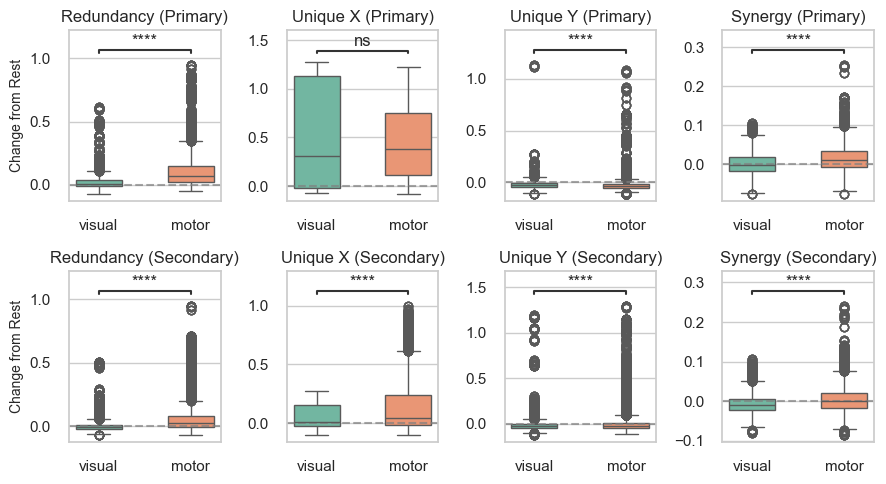

In [6]:
plot_cross_system_pid_comparison(
    [visual_df, motor_df],
    systems=['visual', 'motor'],
    output_file='PID_Comparison.pdf'
)